# Case3-challenge00

At first, we add the analysis directory to the python path.

In [1]:
import sys
sys.path.append('/home/kamizuka/analysis')

At first, we load the data, 'case3_chalenge_00.txt'.

In [2]:
import astropy.io.ascii as asc
from astropy import units as u

data = asc.read('case3_challenge_00.txt')
data['x'].unit = u.um
data['y'].unit = u.um
data['ra'].unit = u.deg
data['dec'].unit = u.deg

The source distribution is shown in the figure below.

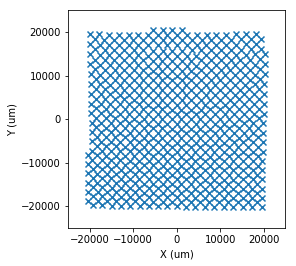

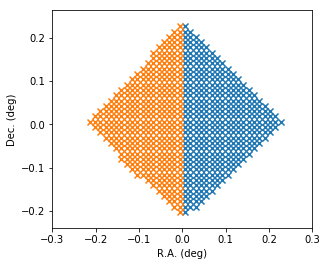

In [4]:
import matplotlib.pylab as plt

fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(111)
ax.scatter(data['x'], data['y'], marker='x')
ax.set_xlabel('X (um)')
ax.set_ylabel('Y (um)')
ax.set_xlim([-25000,25000])
ax.set_ylim([-25000,25000])
ax.set_aspect('equal', adjustable='box')

fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(111)
ax.scatter(data['ra'], data['dec'], marker='x')
ax.scatter(data['ra']-360.0, data['dec'], marker='x')
ax.set_xlabel('R.A. (deg)')
ax.set_ylabel('Dec. (deg)')
ax.set_xlim([-0.3,0.3])
ax.set_aspect('equal', adjustable='box')

We guess the astrometric(?) parameters.

In [5]:
import numpy as np
from astropy.coordinates import SkyCoord, Angle

r = np.sqrt(data['x']**2.+data['y']**2.)
i0 = np.argmin(r)
ra0  = data['ra'].quantity[i0]
dec0 = data['dec'].quantity[i0]

c0 = SkyCoord(ra=ra0, dec=dec0, frame='icrs')
c1 = SkyCoord(ra=data['ra'].quantity[0], dec=data['dec'].quantity[0], frame='icrs')
angle_sep = c0.separation(c1)

dx = data['x'].quantity[i0] - data['x'].quantity[0]
dy = data['y'].quantity[i0] - data['y'].quantity[0]
um_sep = np.sqrt(dx*dx+dy*dy)

scale0 = angle_sep/um_sep

pa0 = 0.0 * u.deg

print(ra0)
print(dec0)
print(scale0)
print(pa0)

0.006122448979591855 deg
0.006122448979591855 deg
7.5505568676706854e-06 deg / um
0.0 deg


We define a model function which calculates RA and Dec from the position on the focal plane. In this example, we consider the focal-plane distortion. It is represented by the Sip function implemented to astropy.wcs. Here, we set the order of the polynomial functions to be 2.

In [6]:
from astropy.wcs import WCS
from astropy.wcs import Sip

def wcs(ra0, dec0, pa0, scale0, a, b):
    w = WCS(naxis=2)
    w.wcs.crpix=[0,0]
    w.wcs.cdelt=np.array([-scale0, scale0])
    w.wcs.crval=[ra0, dec0]
    w.wcs.ctype=["RA---TAN", "DEC--TAN"]
    w.wcs.pc=[[ np.cos(pa0*u.deg), np.sin(pa0*u.deg)],
              [-np.sin(pa0*u.deg), np.cos(pa0*u.deg)]]
    w.sip = Sip(a, b, None, None, [0, 0])
    return w

In [7]:
def model(params, pxcrd):
    ra_ptg  = params[0] # value in deg.
    dec_ptg = params[1] # value in deg.
    pa_ptg  = params[2] # value in deg.
    scale   = params[3] # value in deg/um.
    a = np.array([[0, 0, params[4]], [0, params[5], 0], [params[6], 0, 0]])
    b = np.array([[0, 0, params[7]], [0, params[8], 0], [params[9], 0, 0]])
    # params must be an array of dimension-less values.
    
    w = wcs(ra_ptg, dec_ptg, pa_ptg, scale, a, b)
    world = w.all_pix2world(pixcrd, 0)

    # constraining ra and dec in 'world' between -180 to 180 deg.
    pos = np.where(world>180.)
    world[pos] = world[pos] - 360.
    pos = np.where(world<-180.)
    world[pos] = world[pos] + 360.
    
    return world.T.flatten()

Then, we make an array of the coordinates on the focal plane.

In [8]:
pixcrd = np.concatenate(([data['x']],[data['y']])).T

And now, we estimate the astrometric(?) parameters with the LeastSquare module.

In [9]:
from common.leastsquare import LeastSquare

ls = LeastSquare(lambda a: model(a, pixcrd), np.size(data['x'])*2)

a_init = np.array([ra0.value, dec0.value, pa0.value, scale0.value, 0, 0, 0, 0, 0, 0]) # This must be an ndarray.

# constraining ra/dec values in 'observed' between -180 and 180 deg.
true_pos = np.concatenate((data['ra'], data['dec']))
pos = np.where(true_pos>180.)
true_pos[pos] = true_pos[pos] - 360.
pos = np.where(true_pos<-180.)
true_pos[pos] = true_pos[pos] + 360.

result, _ = ls.solve(true_pos, a_init, max_iteration=100)

if result[3] < 0:
    result[3] = -result[3]
    result[2] = result[2] + 180.0

if result[2] > 360.0 or result[2] < 0.0:
    result[2] = result[2]%360.0

2021-07-05 10:37:21,209  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 42.507106)
2021-07-05 10:37:21,227  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 81.195870)
2021-07-05 10:37:21,244  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 159.170851)
2021-07-05 10:37:21,261  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 26.453286)
2021-07-05 10:37:21,278  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 52.003034)
2021-07-05 10:37:21,296  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 2.971318)
2021-07-05 10:37:21,311  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 1.215990)
2021-07-05 10:37:21,328  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000976)
20

The result is...

In [10]:
print("Center R.A.   : {:f} deg.".format(result[0]))
print("Center Dec.   : {:f} deg.".format(result[1]))
print("Position angle: {:f} deg.".format(result[2]))
print("Plate scale   : {:e} deg/um".format(result[3]))

Center R.A.   : 0.000039 deg.
Center Dec.   : 0.000069 deg.
Position angle: 134.834334 deg.
Plate scale   : 7.899158e-06 deg/um


In [11]:
print(result[4:7])
print(result[7:10])

[-1.59971219e-07 -1.14853313e-06 -4.79827465e-07]
[-1.75152071e-06 -3.28324992e-07 -5.60445234e-07]


According to the meta part of the input file, the poiunting RA and Dec are 0.0 deg. The position angle is 134.8344427850505 deg. The calculation seems to correctly estimate these parameters.

Let's compare the ra/dec values calculated from the derived parameters with the true values.

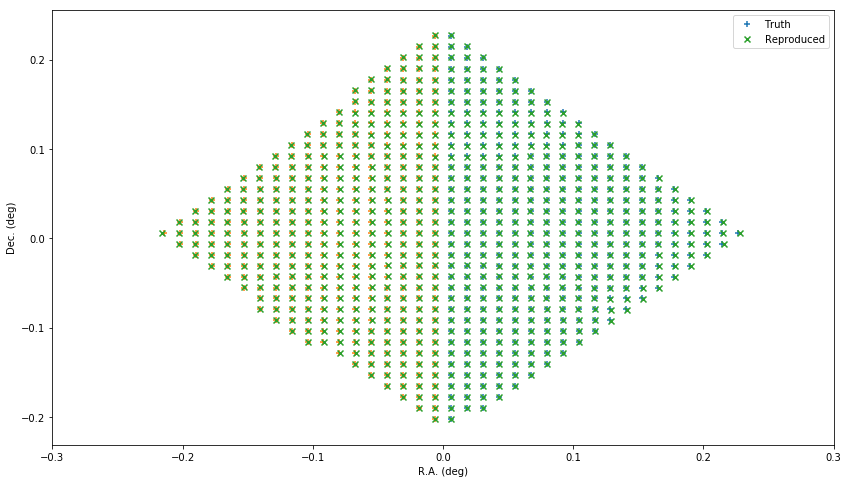

In [12]:
positions = model(result, pixcrd)
positions = positions.reshape((2,int(positions.size/2))).T

fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(111)
ax.scatter(data['ra'], data['dec'], marker='+', label='Truth')
ax.scatter(data['ra']-360., data['dec'], marker='+', label='')
ax.scatter(positions[:,0], positions[:,1], marker='x', label='Reproduced')
ax.set_xlabel('R.A. (deg)')
ax.set_ylabel('Dec. (deg)')
ax.set_xlim([-0.3,0.3])
#ax.set_aspect('equal', adjustable='box')
ax.legend()

This plot shows that the reproduced ra/dec values match the true values. (But we still confirm small differences between them.)

In [13]:
from astropy.coordinates import SkyCoord

c_calc = SkyCoord(positions[:,0]*u.deg, positions[:,1]*u.deg, frame='icrs')
c_true = SkyCoord(data['ra'], data['dec'], frame='icrs')
sep = c_calc.separation(c_true)

Text(0, 0.5, 'Position estimation error (arcsec)')

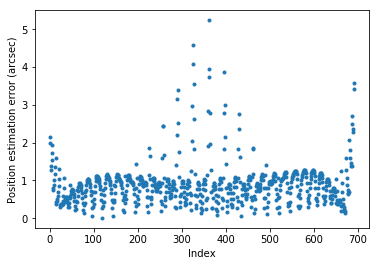

In [14]:
plt.plot(sep.arcsec, '.')
plt.xlabel('Index')
plt.ylabel('Position estimation error (arcsec)')

The above plot shows that the typical positional differences between the reproduced positions and the true positions are around 1 arcsec. It seems to be too large. Higher-order polynomial functions might be needed to represent the distortion in this problem.

If the distortion is not considered, the position matching becomes worse as shown below.

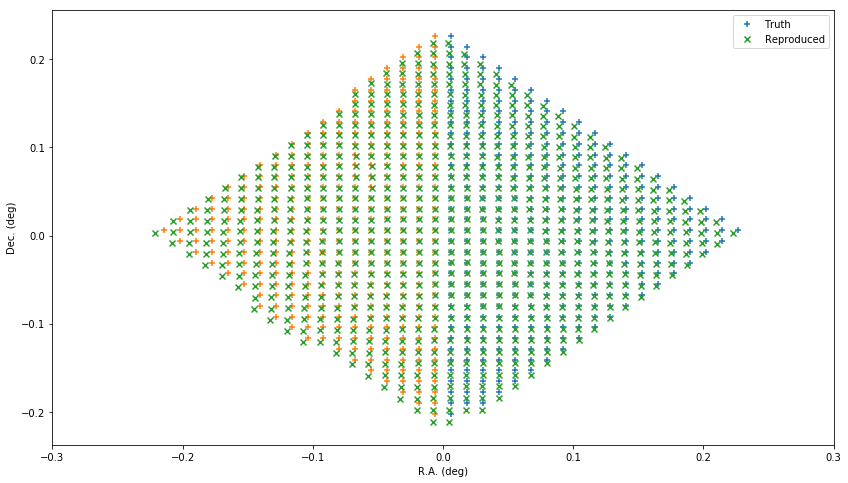

In [15]:
positions = model([result[0], result[1], result[2], result[3], 0, 0, 0, 0, 0, 0], pixcrd)
positions = positions.reshape((2,int(positions.size/2))).T

fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(111)
ax.scatter(data['ra'], data['dec'], marker='+', label='Truth')
ax.scatter(data['ra']-360., data['dec'], marker='+', label='')
ax.scatter(positions[:,0], positions[:,1], marker='x', label='Reproduced')
ax.set_xlabel('R.A. (deg)')
ax.set_ylabel('Dec. (deg)')
ax.set_xlim([-0.3,0.3])
#ax.set_aspect('equal', adjustable='box')
ax.legend()